In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import cftime
import calendar
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.ticker as mticker
from matplotlib.colors import TwoSlopeNorm
import imageio
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime

In [2]:
t2m_all_forcing_tes1 = xr.open_dataset('/nird/datalake/NS1004K/elihho/tes0004_echam6_BOT_mm_0_1850_var167.nc')
t2m_all_forcing_slo1 = xr.open_dataset('/nird/datalake/NS1004K/elihho/slo0059_echam6_BOT_mm_0_1850_var167.nc')

tas_orb_GHG = xr.open_dataset('slo0043_echam6_BOT_mm_1001-8850_167_NH.nc')
tas_all_forcing = xr.open_dataset('slo0042+slo0046+slo0050_echam6_BOT_mm_1001_8850_167_NH.nc')
tas_orb_GHG = tas_orb_GHG.sel(time=slice(70010131.994444, 88501231.994444))
tas_all_forcing = tas_all_forcing.sel(time=slice(70010131.994444, 88501231.994444))

In [3]:
#Function to convert time to date time object

#Split up in yyyy, mm and dd lists
def convert_time(time_array):
    #Converting time to pandas dataframe
    time_df = pd.DataFrame(time_array)#-0.99444445

    #Create empty lists
    time = []
    year = []
    month = []
    date = []
    
    #Split up date format in year, month and day
    for i in range(0,len(time_df[0])):
        time.append(str(time_df[0][i]))
        year.append(int(time[i][0:4])-7001)
        month.append(time[i][4:6])
    
    #Add lists to dataframe
    time_df['year']=year
    time_df['month']=month
    #Get the right format (str, yyyy, mm)
    yyyy=time_df['year'].astype("string").str.zfill(4)
    mm=time_df['month'].astype("string")

    #Combine to datestring in format 'yyyy-mm'
    for i in range(0,len(time_df[0])):
        date_stamp = f'{yyyy[i]}-{mm[i]}'
        date.append(date_stamp)

    #Add date string to dataframe
    time_df['date'] = date
    
    #Convert to datetime object. Works from year 0001!
    def convert_to_datetime(date_str):
        try:
            return datetime.strptime(date_str, '%Y-%m')
        except ValueError as e:
            print(f"Error converting date {date_str}: {e}")
            return pd.NaT
    
    # Apply the conversion function to the 'date' column
    time_df['date'] = time_df['date'].apply(convert_to_datetime)
    return time_df['date']

In [4]:
time_t2m_tes = convert_time(t2m_all_forcing_tes1['time'])
time_t2m_slo = convert_time(t2m_all_forcing_slo1['time'])
time_tas_orb_GHG = convert_time(tas_orb_GHG['time'])
time_tas_all_forcing = convert_time(tas_all_forcing['time'])

Error converting date 0000-01: year 0 is out of range
Error converting date 0000-02: year 0 is out of range
Error converting date 0000-03: year 0 is out of range
Error converting date 0000-04: year 0 is out of range
Error converting date 0000-05: year 0 is out of range
Error converting date 0000-06: year 0 is out of range
Error converting date 0000-07: year 0 is out of range
Error converting date 0000-08: year 0 is out of range
Error converting date 0000-09: year 0 is out of range
Error converting date 0000-10: year 0 is out of range
Error converting date 0000-11: year 0 is out of range
Error converting date 0000-12: year 0 is out of range
Error converting date 0000-01: year 0 is out of range
Error converting date 0000-02: year 0 is out of range
Error converting date 0000-03: year 0 is out of range
Error converting date 0000-04: year 0 is out of range
Error converting date 0000-05: year 0 is out of range
Error converting date 0000-06: year 0 is out of range
Error converting date 0000-0

In [5]:
t2m_tes = t2m_all_forcing_tes1.assign_coords(time = ('time', list(time_t2m_tes)))
t2m_slo = t2m_all_forcing_slo1.assign_coords(time = ('time', list(time_t2m_slo)))
tas_orb_GHG = tas_orb_GHG.assign_coords(time = ('time', list(time_tas_orb_GHG)))
tas_all_forcing = tas_all_forcing.assign_coords(time = ('time', list(time_tas_all_forcing)))

In [6]:
t2m_tes_lia = t2m_tes.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))
t2m_slo_lia = t2m_slo.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))

tas_orb_GHG_lia = tas_orb_GHG.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))
tas_all_forcing_lia = tas_all_forcing.sel(time=slice(datetime(1250, 1, 1, 0, 0), datetime(1849, 11, 1, 0, 0)))

In [7]:
# Extract latitude
lat = t2m_tes_lia['lat']

# Calculate weights: cos(lat) in radians
weights = np.cos(np.deg2rad(lat))

scand_lat = slice(89, 50)
scand_lon = slice(-10, 50)

scand_lia_tes = t2m_tes_lia['var167'].sel(lat=scand_lat, lon = scand_lon).weighted(weights).mean(dim=['lat', 'lon'])
scand_lia_slo = t2m_slo_lia['var167'].sel(lat=scand_lat, lon = scand_lon).weighted(weights).mean(dim=['lat', 'lon'])
scand_orb_GHG_lia = tas_orb_GHG_lia['var167'].sel(lat=scand_lat, lon = scand_lon).weighted(weights).mean(dim=['lat', 'lon'])
scand_all_forcing_lia = tas_all_forcing_lia['var167'].sel(lat=scand_lat, lon = scand_lon).weighted(weights).mean(dim=['lat', 'lon'])

In [8]:
def calculate_yearly_mean(array):
    # Assuming 'time' contains datetime.datetime objects
    years = [t.year for t in array['time'].values]
    months = [t.month for t in array['time'].values]
    # Add these as coordinates to your DataArray
    array['year'] = ('time', years)
    array['month'] = ('time', months)

    yearly_mean_data = array.groupby('year').mean(dim='time')
    return yearly_mean_data

In [9]:
yearly_mean_tes = calculate_yearly_mean(scand_lia_tes)
yearly_mean_slo = calculate_yearly_mean(scand_lia_slo)
yearly_mean_orb_GHG = calculate_yearly_mean(scand_orb_GHG_lia)
yearly_mean_all_forcing = calculate_yearly_mean(scand_all_forcing_lia)

In [10]:
eruptions = [1257, 1477, 1510, 1585, 1595, 1640, 1667, 1673, 1707, 1721, 1739, 1755, 1766, 1783, 1815, 1822, 1831]

In [11]:
def superposed_epoch_analysis(data, eruption_years, window_before=5, window_after=5):
    window_length = window_before + window_after + 1
    all_anomalies = []

    for year in eruption_years:
        start_year = year - window_before
        end_year = year + window_after

        # Ensure the window is fully within the data range
        if (start_year in data.year.values) and (end_year in data.year.values):
            event = data.sel(year=slice(start_year, end_year))

            if event.size == window_length:
                pre_event_mean = event.sel(year=slice(year - window_before, year - 1)).mean().item()
                anomaly = event - pre_event_mean
                all_anomalies.append(anomaly.values)

    if not all_anomalies:
        raise ValueError("No valid eruption events with complete windows found.")

    stacked = np.stack(all_anomalies)
    mean_anomaly = stacked.mean(axis=0)
    std_anomaly = stacked.std(axis=0)
    window = np.arange(-window_before, window_after + 1)

    return window, mean_anomaly, std_anomaly

In [12]:
window_tes, mean_response_tes, std_response_tes = superposed_epoch_analysis(
    yearly_mean_tes,
    eruptions,
    window_before=5,
    window_after=10
)

window_slo, mean_response_slo, std_response_slo = superposed_epoch_analysis(
    yearly_mean_slo,
    eruptions,
    window_before=5,
    window_after=10
)

window_orb_GHG, mean_response_orb_GHG, std_response_orb_GHG = superposed_epoch_analysis(
    yearly_mean_orb_GHG,
    eruptions,
    window_before=5,
    window_after=10
)

window_all_forcing, mean_response_all_forcing, std_response_all_forcing = superposed_epoch_analysis(
    yearly_mean_all_forcing,
    eruptions,
    window_before=5,
    window_after=10
)

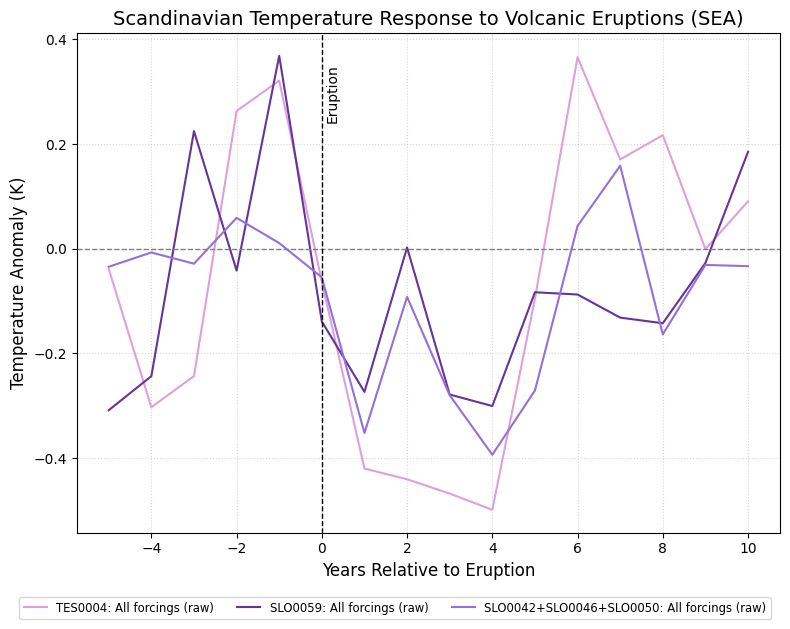

In [19]:
fig, ax = plt.subplots(figsize = (8, 6))

ax.plot(window_tes, mean_response_tes, color = 'plum', label = 'TES0004: All forcings (raw)')
ax.plot(window_slo, mean_response_slo, color = 'rebeccapurple', label = 'SLO0059: All forcings (raw)')
#ax.plot(window_orb_GHG, mean_response_orb_GHG, color = 'rebeccapurple', label = 'SLO0043: orbital, GHG (raw)')
ax.plot(window_all_forcing, mean_response_all_forcing, color = 'mediumpurple', label = 'SLO0042+SLO0046+SLO0050: All forcings (raw)')

ax.axhline(0, color='gray', linestyle='--', lw=1)
ax.axvline(0, color='black', linestyle='--', lw=1) 
ax.text(0.1, ax.get_ylim()[1]*0.6, 'Eruption', rotation=90, color='black')

ax.set_ylabel('Temperature Anomaly (K)', fontsize=12)
ax.set_xlabel('Years Relative to Eruption', fontsize=12)
ax.set_title('Scandinavian Temperature Response to Volcanic Eruptions (SEA)', fontsize=14)

ax.grid(True, linestyle=':', alpha=0.5)

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
    fontsize='small',
    frameon=True
)

plt.tight_layout()
plt.show()

In [14]:
def rolling_mean(data, window):
    return np.convolve(data, np.ones(window)/window, mode='same')

In [15]:
mean_response_tes_smoothed = rolling_mean(mean_response_tes, window=3)
mean_response_slo_smoothed = rolling_mean(mean_response_slo, window=3)
mean_response_all_forcing_smoothed = rolling_mean(mean_response_all_forcing, window=3)

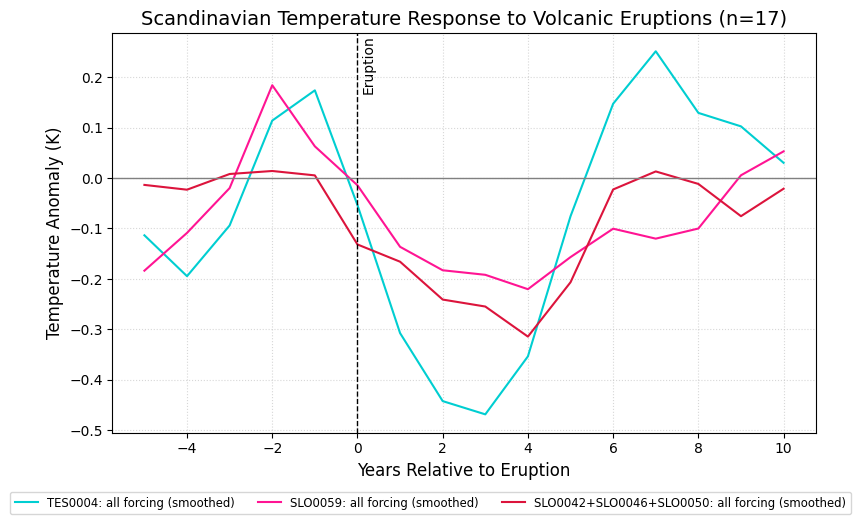

In [18]:
fig, ax = plt.subplots(figsize=(8, 5))

# Smoothed lines
ax.plot(window_tes, mean_response_tes_smoothed, color='darkturquoise', label='TES0004: all forcing (smoothed)')
ax.plot(window_slo, mean_response_slo_smoothed, color='deeppink', label='SLO0059: all forcing (smoothed)')
ax.plot(window_all_forcing, mean_response_all_forcing_smoothed, color='crimson', label='SLO0042+SLO0046+SLO0050: all forcing (smoothed)')

ax.axhline(0, color='gray', linestyle='-', lw=1)
ax.axvline(0, color='black', linestyle='--', lw=1) 
ax.text(0.1, ax.get_ylim()[1]*0.6, 'Eruption', rotation=90, color='black')

ax.set_ylabel('Temperature Anomaly (K)', fontsize=12)
ax.set_xlabel('Years Relative to Eruption', fontsize=12)
ax.set_title(f'Scandinavian Temperature Response to Volcanic Eruptions (n={len(eruptions)})', fontsize=14)

ax.grid(True, linestyle=':', alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.05),
    ncol=6,
    fontsize='small',
    frameon=True
)
plt.tight_layout()
plt.show()
